# ロジスティック回帰
Iris Speciesのデータセットを使用して、ロジスティック回帰アルゴリズムによるモデルを構築

## データ取得

データセット：Iris Species  
https://www.kaggle.com/uciml/iris/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

iris_df = pd.read_csv('input/Iris.csv')
iris_df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


## ２値分類
今回は以下のクラスを分類
- Iris-versicolor
- Iris-virginica

In [2]:
iris_df=iris_df[iris_df["Species"]!="Iris-setosa"]

x_df=iris_df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
y_df=iris_df[["Species"]]

In [3]:
y_df["Species"].unique()

array(['Iris-versicolor', 'Iris-virginica'], dtype=object)

## EDA

In [4]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 50 to 149
Data columns (total 6 columns):
Id               100 non-null int64
SepalLengthCm    100 non-null float64
SepalWidthCm     100 non-null float64
PetalLengthCm    100 non-null float64
PetalWidthCm     100 non-null float64
Species          100 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 5.5+ KB


- 総データ数100（Iris-setosaデータ除く）
- IDを除いて４つの特徴（花弁とがく片それぞれの長さと幅）
- null値なし
- 説明変数は、すべて数値
- 目的変数はカテゴリカルデータ

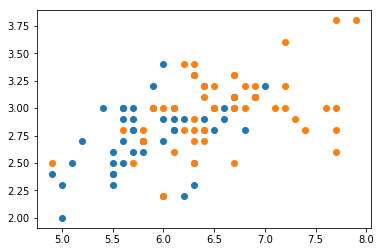

In [7]:
iris_versicolor = iris_df[iris_df['Species'] == 'Iris-versicolor']
iris_virginica  = iris_df[iris_df['Species']=='Iris-virginica']

plt.plot(iris_versicolor["SepalLengthCm"], iris_versicolor['SepalWidthCm'], 'o')
plt.plot(iris_virginica["SepalLengthCm"], iris_virginica['SepalWidthCm'], 'o')

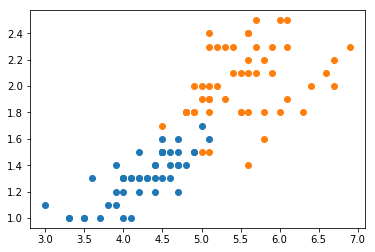

In [9]:
plt.plot(iris_versicolor['PetalLengthCm'], iris_versicolor['PetalWidthCm'], 'o')
plt.plot(iris_virginica['PetalLengthCm'], iris_virginica['PetalWidthCm'], 'o')

## 数式の実装

### sigmoid function（シグモイド関数）

$g(z) = \frac{1}{1 + e^{-z}}$

In [337]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

sigmoid(0.5)

0.6224593312018546

### なぜロジスティック回帰はシグモイド関数を用いるのか

前提として予測する出力が数値ではなくカテゴリーに属するかどうかの確率になる。
このため

- $h_\theta(x)$がどんな値を取ったときも0から1の値を取ることができる。
- $x_1 < x_2$のとき$h_\theta(x_1) < h_\theta(x_2)$が成り立つ。
- $\theta^Tx$ の正負で分類ができるので判定が簡単

上記を満たすためロジスティック関数ではシグモイド関数を用いる。

### シグモイド関数を描画

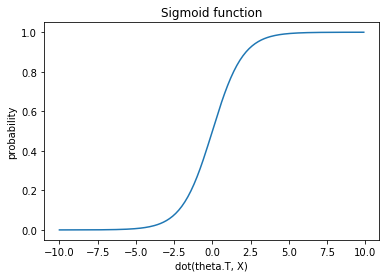

In [338]:
import math

x = np.arange(-10, 10, 0.1)
e = math.e

y = 1 / (1 + e**-x)

plt.plot(x, y)
plt.xlabel("dot(theta.T, X)")
plt.ylabel("probability")
plt.title("Sigmoid function")
plt.show()

### 正則化とは

モデルが複雑（高次数、多特徴量）であるほど、表現力が高くなり、実測値に対して過剰適合（過学習）を起こしやすくなる。  
正則化とは、各特徴量の係数に当たるパラメータ $\theta$（重み）の値を小さくさせ（ペナルティを与えて）、$\theta$が大きい値を取らないように補正することである。

## ロジスティック回帰における、目的関数（コスト関数）
ロジスティック回帰における目的関数（コスト関数）を実装  

$h_θ(x) = g(θ^T x).$

$g(z) = \frac{1}{1 + e^{-z}}$

$J(\theta) = \frac{1}{m} \displaystyle\sum_{i=1}^{m}[-y^{(i)} log(h_\theta(x^{(i)})) - (1 - y^{(i)}) log(1 - h_\theta(x^{(i)}))] +
\frac{λ}{2m} \displaystyle\sum_{j=1}^n
\theta^2_j.$

In [10]:
# 切片追加
x_df["x0"] = 1
# 切片カラムを列の先頭に並び替え
x_df=x_df.iloc[:,[4, 0,1,2,3]]

/Users/enomoto/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
# 初期値パラメーター設定（切片含め特徴量が５つあるため）
theta = np.random.rand(5)

In [12]:
# 固有の要素を取得
y_df["Species"].unique()
# enumerate：インデックス番号、要素の順位に取得
class_mapping = {x:i for i, x in enumerate(y_df["Species"].unique())}
# カテゴリカルデータを数値に変換
# Iris-versicolor→0
# Iris-virginica→1
y_df["Species"]=y_df["Species"].map(class_mapping)

/Users/enomoto/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [342]:
def compute_cost(X, y, theta, lam):
    # 仮説関数作成→各データの行列積を取得
    z=np.dot(X,theta)
    # シグモイド関数に代入
    sig=sigmoid(z)
    # 総データ数
    m=len(X)
    # 正則化項：regularization
    reg_term=(lam / (2*m))*(theta**2).sum()
    # 目的関数
    return (-1*y*np.log(sig) - (1 - y)*np.log(1 - sig)).sum() / m + reg_term

X=x_df
y=y_df["Species"]
lam=0.01

compute_cost(X, y, theta, lam)

5.237056250704451

## 二乗誤差と交差エントロピー誤差★
なぜロジスティック回帰では二乗誤差ではなく交差エントロピー誤差関数を目的関数とするのか。

**回帰問題の目的は予測した誤差を最小にするのが目的であるのに対し、
分類問題の目的はそれぞれのデータがあるクラスと予測する確率を出し、すべてのデータで予測した分類が正解する、つまりそれぞれの事象の同時確率が最大になることが目的となるため。**

各データの同時確率（積集合）が目的関数になる。
これだとそれぞれ0~1の値を取るためデータ数が増えるとアンダーフローになり正しく判定できなくなる。
これを防ぐために対数をとった式が今回採用する交差誤差エントロピー誤差関数となる。
(合わせて正規化もできるというメリットもある。）


それぞれのデータのクラスに分類できる確率の同時確率は下記で表される。
この確率を最大化したい。

$J(\theta) = \frac{1}{m} \displaystyle \prod_{i=1}^m [y^{(i)}prob(x)^{(i)}+(1-y)^{(i)}(1-prob(x^{(i)}))]$

これだと各データの分類確率が0~1なのでかなり小さい値になってしまい、プログラム計算上不都合なので対数を取る。


$ J(\theta) = \frac{1}{m} log \displaystyle \prod_{i=1}^m [y^{(i)}prob(x)^{(i)}+(1-y)^{(i)}(1-prob(x^{(i)}))]$

$\log ab = \log a + \log b$ の性質より

$ J(\theta) = \frac{1}{m} log \displaystyle \prod_{i=1}^m [y^{(i)}prob(x)^{(i)}+(1-y)^{(i)}(1-prob(x^{(i)}))]$

## 最急降下法(勾配降下法、GradientDescent)

$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)}  ,j = 0$

$\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　 ,j\geq 1$

In [343]:
def gradient_descent(X, y, theta, iterations, alpha, lam):

    # alpha：学習率（ステップ数）
    # iterations：反復回数
    
    past_costs = []
    past_thetas = []
    
    # j=0のとき、正則化項を0にする
    zero_or_one = np.ones(len(theta))
    zero_or_one[0]= 0
    
    # 総データ数
    m=len(X)
    
    for a in range(iterations):
        # 正則化項
        reg_term = lam * theta * zero_or_one
        z=np.dot(X,theta)
        sig=sigmoid(z)
        # パラメーター更新
        theta = theta - alpha / m * (np.dot(X.T, (sig - y)) + reg_term)
        past_costs.append(compute_cost(X, y, theta, lam))
        past_thetas.append(theta)
    return past_costs,past_thetas

alpha=0.01
iterations=200

(past_costs,past_thetas)=gradient_descent(X, y, theta, iterations, alpha, lam)

## 学習曲線のプロット

In [352]:
def plot_learning_curve(X, y, theta, iterations, alpha, lam):
    # データを用意
    past_costs, past_thetas = gradient_descent(X, y, theta, iterations, alpha, lam)
    
    plt.figure(figsize=(12, 8))
    plt.plot(range(iterations), past_costs)

    # 座標系の名前
    plt.title('Learning Curve')
    # x軸の名前
    plt.xlabel("Iterations")
    # y軸の名前
    plt.ylabel("Cost")
    plt.show()

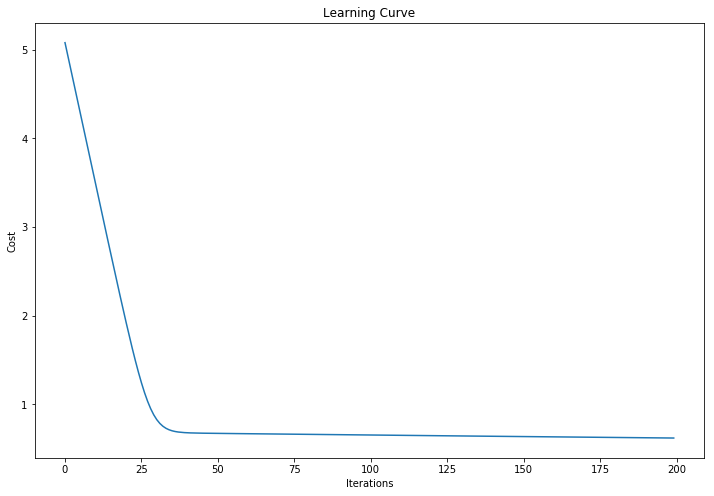

In [353]:
plot_learning_curve(X, y, theta, iterations, alpha, lam)

## 予測関数
学習済の分類器を使用して、実際に予測を行う関数を作成

In [346]:
# 各データの分類確率を求める
def predict_probs(X, theta):
    z=np.dot(X,theta)
    sig=sigmoid(z)
    return sig

In [347]:
# past_thetas[-1]：学習曲線で最も収束した時のパラメータを取得
predict_probs(X, past_thetas[-1])

array([0.45092679, 0.51654135, 0.47237237, 0.48092025, 0.47159503,
       0.5331123 , 0.55742171, 0.48985222, 0.44988568, 0.55782295,
       0.45007546, 0.53639745, 0.38744696, 0.51968991, 0.50848814,
       0.45871769, 0.58354688, 0.46132199, 0.4408964 , 0.46386228,
       0.61521157, 0.46434638, 0.47920498, 0.48921922, 0.45654052,
       0.45985158, 0.43884673, 0.51014897, 0.53085044, 0.43255545,
       0.45998568, 0.44473292, 0.47189893, 0.55174804, 0.60460597,
       0.5891614 , 0.48410398, 0.41457653, 0.54335967, 0.50046386,
       0.52003927, 0.52441642, 0.46718079, 0.46919555, 0.51917082,
       0.52721167, 0.52778654, 0.47828006, 0.47304859, 0.51299514,
       0.70381486, 0.60331953, 0.55305671, 0.58384335, 0.62159129,
       0.53390044, 0.62956423, 0.5107469 , 0.51194448, 0.64793309,
       0.58675231, 0.5492428 , 0.56547008, 0.60013447, 0.66049093,
       0.6361724 , 0.56713482, 0.61456914, 0.51974678, 0.48766056,
       0.60374224, 0.63340482, 0.49816939, 0.52976977, 0.61413

In [348]:
# 確率を閾値で分類
# threshold：閾値
def predict(X, theta, threshold=0.5):
    # 各データの分類確率を取得
    probs=predict_probs(x_df, past_thetas[-1])
    species=[]
    for i in range(len(X)):
        if probs[i] >= threshold:
            species.append('Iris-virginica')
        else:
            species.append('Iris-versicolor')
    return species

In [349]:
#予測分類データ
pred= predict(X,past_thetas[-1])

In [350]:
#実測分類データ
real=iris_df["Species"].values.tolist()

In [351]:
# 正解率
count = 0
for i in range(len(pred)):
    if pred[i] == real[i]:
        count += 1
print('正解率：'+str(count/100))

正解率：0.74


## クラス化
今まで作成した関数のクラス化

In [375]:
class LogisticModel():

    def __init__(self):
        pass
        
    def compute_cost(self, X, y, theta, lam):
        z=np.dot(X, theta)
        sig=sigmoid(z)
        m=len(X)
        reg_term=(lam / (2*m))*(theta**2).sum()
        return (-1*y*np.log(sig) - (1 - y)*np.log(1 - sig)).sum() / m + reg_term
    
    def gradient_descent(self, X, y, theta, iterations, alpha, lam):

        past_costs = []
        past_thetas = []
        zero_or_one = np.ones(len(theta))
        zero_or_one[0]= 0
        m=len(X)

        for a in range(iterations):
            reg_term = lam * theta * zero_or_one
            z=np.dot(X,theta)
            sig=sigmoid(z)
            theta = theta - alpha / m * (np.dot(X.T, (sig - y)) + reg_term)
            past_costs.append(self.compute_cost(X, y, theta, lam))
            past_thetas.append(theta)
        return past_costs, past_thetas
    
    def plot_learning_curve(self, X, y, theta, iterations, alpha, lam):
        past_costs, past_thetas = self.gradient_descent(X, y, theta, iterations, alpha, lam)

        plt.figure(figsize=(12, 8))
        plt.plot(range(iterations), past_costs)
        plt.title('Learning Curve')
        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        plt.show()

In [381]:
# LinearModelオブジェクト作成
model = LogisticModel()
theta = np.random.rand(5)

In [382]:
# 目的関数
model.compute_cost(X, y, theta, 0.01)

5.681967925219509

In [383]:
# 最急降下法
(past_costs,past_thetas)=model.gradient_descent(X, y, theta, 400, 0.01, 0.01)

In [385]:
pred= predict(x_df,past_thetas[-1])

# 正解率
count = 0
for i in range(len(pred)):
    if pred[i] == real[i]:
        count += 1
print("正解率："+str(count/100))

正解率：0.92


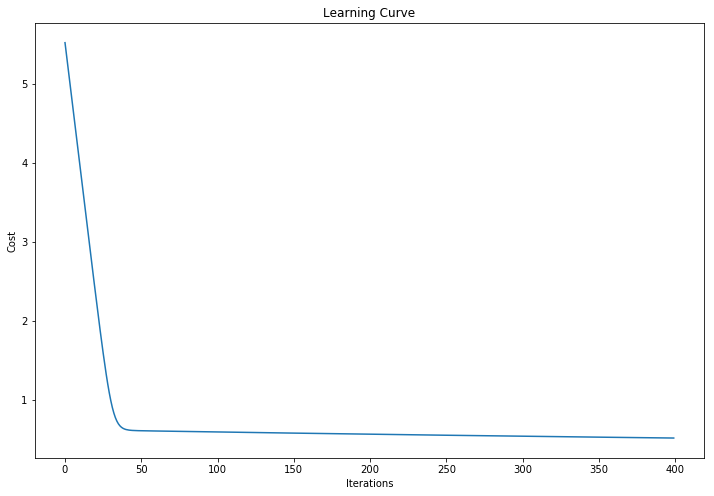

In [386]:
# 学習曲線
model.plot_learning_curve(X, y, theta, 400, 0.01, 0.01)